## Multivariate decision trees

In this section we show how to develop the OC1 decision tree method.

OC1 classifier is divided into several steps:
1. Get all possible hyperplanes $H_{i}$.
2. Choose one.
3. Perturb and find $v_{j}$.
4. Calculate gini index of each $H_{i}$.
5. Choose $H_{i}$ with lowest gini index.

Let's import required libraries.

In [1]:
import numpy as np
from random import randint, random
import pydot

We should restore the ``data_set`` and ``labels`` from the previous notebook.

In [2]:
%store -r data_set
%store -r labels

The Leaf class is the same as below.

In [3]:
class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

Compare to C4.5 and CART we have one more variable ``R`` which is a parameter that is used to set the number of loops to randomly choose the feature to check if feature change can give better split. See ``build_level()``.

In [4]:
ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root
R = 10

In the method below we compute the $V_{j}$ which gives us the knowledge if a given object is above or below the hiperplane. It can be formulated as:
$\sum_{i=1}^{d}a_{i}x_{i}+a_{d+1}>0$, where $a_{1},\ldots,a_{d+1}$ are coefficients. In our case $a_{d+1}$ is our label.

In [5]:
def compute_v(element, scv):
    return np.sum(np.multiply(element, scv[:-1])) + scv[-1]

def compare_two_leafs(leaf1, leaf2):
    labels1 = leaf1.labels
    labels2 = leaf2.labels
    if len(labels1) == len(labels2):
        for i in range(len(labels1)):
            if labels1[i] != labels2[i]:
                return False
        return True
    return False

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

The gini index can be calculated as shown below. Please keep in mind that it's only the gini index for a given split and need to be subtracted with 1 as shown in ``get_all_possible_splits_by_gini`` method.

In [6]:
def calculate_gini(labels):
    unique_labels = np.unique(labels)
    gini = 0
    for label in unique_labels:
        found = np.where(labels == label)
        gini = gini + len(found)/len(labels)
    return np.square(gini)

In the method below we calculated all possible hyperplane by calculating the gini indices for each feature. It is kind of similar to what we have done in CART method, but it will be "fixed" during the perturb part of the  OC1 method.

In [7]:
def get_all_possible_splits_by_gini(leaf):
    leaf_elements = leaf.elements
    labels = leaf.labels
    ginis = []
    for i in range(len(leaf_elements[0])):
        feature_ginis = []
        feature_column = np.array(leaf_elements)[:, i]
        for feature in feature_column:
            distinguish = feature_column <= feature
            left_labels  = np.array(labels)[distinguish]
            right_labels = np.array(labels)[~distinguish]
            gini = 1 - calculate_gini(left_labels) - calculate_gini(right_labels)
            feature_ginis.append([feature,gini])
        ginis.append(min(feature_ginis))
    return ginis

We have also a method to find the current leaf to be splitted. It uses the utils that have implemented above.

In [8]:
def find_current_level_data(root):
    return is_leaf_completed(root)

The next step is to divide objects in the leaf into two sets which are above and below the hyperplane.

In [9]:
def divide_data_hiperplane(leaf,scv):
    below = []
    above = []
    below_labels = []
    above_labels = []
    below_ids = []
    above_ids = []
    for i in range(len(leaf.elements)):
        v = compute_v(leaf.elements[i],scv) > 0
        if v:
            above.append(leaf.elements[i])
            above_labels.append(leaf.labels[i])
            above_ids.append(leaf.ids[i])
        else:
            below.append(leaf.elements[i])
            below_labels.append(leaf.labels[i])
            below_ids.append(leaf.ids[i])
    return np.array(below), np.array(above), np.array(below_labels), np.array(above_labels), below_ids, above_ids

The coefficients that we have used above can be calculated as following:

In [10]:
def get_coefficiency(splits):
    splits = np.array(splits)
    scv = np.zeros(len(splits)+1)
    min_split_index = np.argmin(splits[:,1])
    scv[min_split_index] = 1
    scv[-1] = -splits[min_split_index][1]
    return scv

To compute the assignment array can be calculated as: $U_{j}=\frac{a_{m}x_{jm}-V_{j}}{x_{jm}}$.

In [11]:
def compute_u(element, scv, feature):
    return (scv[feature] * element[feature] - compute_v(element, scv)) / element[feature]

A short method for sorting the $U$ for the split can be implemented as below. We use it in the perturb function below.

In [12]:
def sort_u(element):
    return np.sort(element)

Perturb function is the core part of the OC1 method. It calculates different gini indices for different feature combinations. We get the combination with best gini index. We "fix" the previously calculated coefficients.

In [13]:
def perturb(leaf, scv, feature, old_gini):
    u=[]
    for element in leaf.elements:
        u.append(compute_u(element, scv, feature))
    splits = sort_u(np.array(u))
    am = []
    for split in splits:
        new_scv = scv
        new_scv[feature] = split
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf, scv)
        gini = 1 - (calculate_gini(below_label) - calculate_gini(above_label))
        am.append([new_scv, gini])
    am = np.array(am)
    best_split_index = np.argmin(am[:,1])
    if am[best_split_index][1] < old_gini:
        return am[best_split_index][1], am[best_split_index][0]
    elif am[best_split_index][1] == old_gini:
        if random() < 0.3:
            return am[best_split_index][1], am[best_split_index][0]
    return old_gini, scv

The build_level method combine the above functions and split the data into two leafs, assign it and/or stop building the tree if no more leafs to be divided are found.

In [14]:
def build_level(root, split_history):
    leaf = find_current_level_data(root)
    if leaf == None:
        return
    splits = get_all_possible_splits_by_gini(leaf)
    split_coefficiency_vector = get_coefficiency(splits)
    below,above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    gini = 1 - calculate_gini(below_label) - calculate_gini(above_label)
    for c in range(R):
        feature = randint(0,len(leaf.elements[0])-1)
        gini, split_coefficiency_vector = perturb(leaf, split_coefficiency_vector, feature, gini)
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    left_leaf = BinaryLeaf(below, below_label, below_ids)
    right_leaf = BinaryLeaf(above, above_label, above_ids)
    split_history.append([str(leaf.ids), str(left_leaf.ids)])
    split_history.append([str(leaf.ids), str(right_leaf.ids)])
    leaf.set_completed()
    if len(np.unique(below_label)) == 1:
        left_leaf.set_completed()
    if len(np.unique(above_label)) == 1:
        right_leaf.set_completed()
    if compare_two_leafs(leaf, left_leaf) or compare_two_leafs(leaf,right_leaf):
        leaf.set_completed()
    else:
        leaf.set_R(right_leaf)
        leaf.set_L(left_leaf)
    build_level(root, split_history)
    return root, split_history

Execute the level building function.

In [15]:
def build(root):
    split_history = []
    return build_level(root, split_history)

In [16]:
oc1_tree, split_history_oc1 = build(root)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Plot function is the same as in the previous methods:

In [17]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('oc1_tree.png', format='png')
    
plot_tree(split_history_oc1)    

And display the tree:

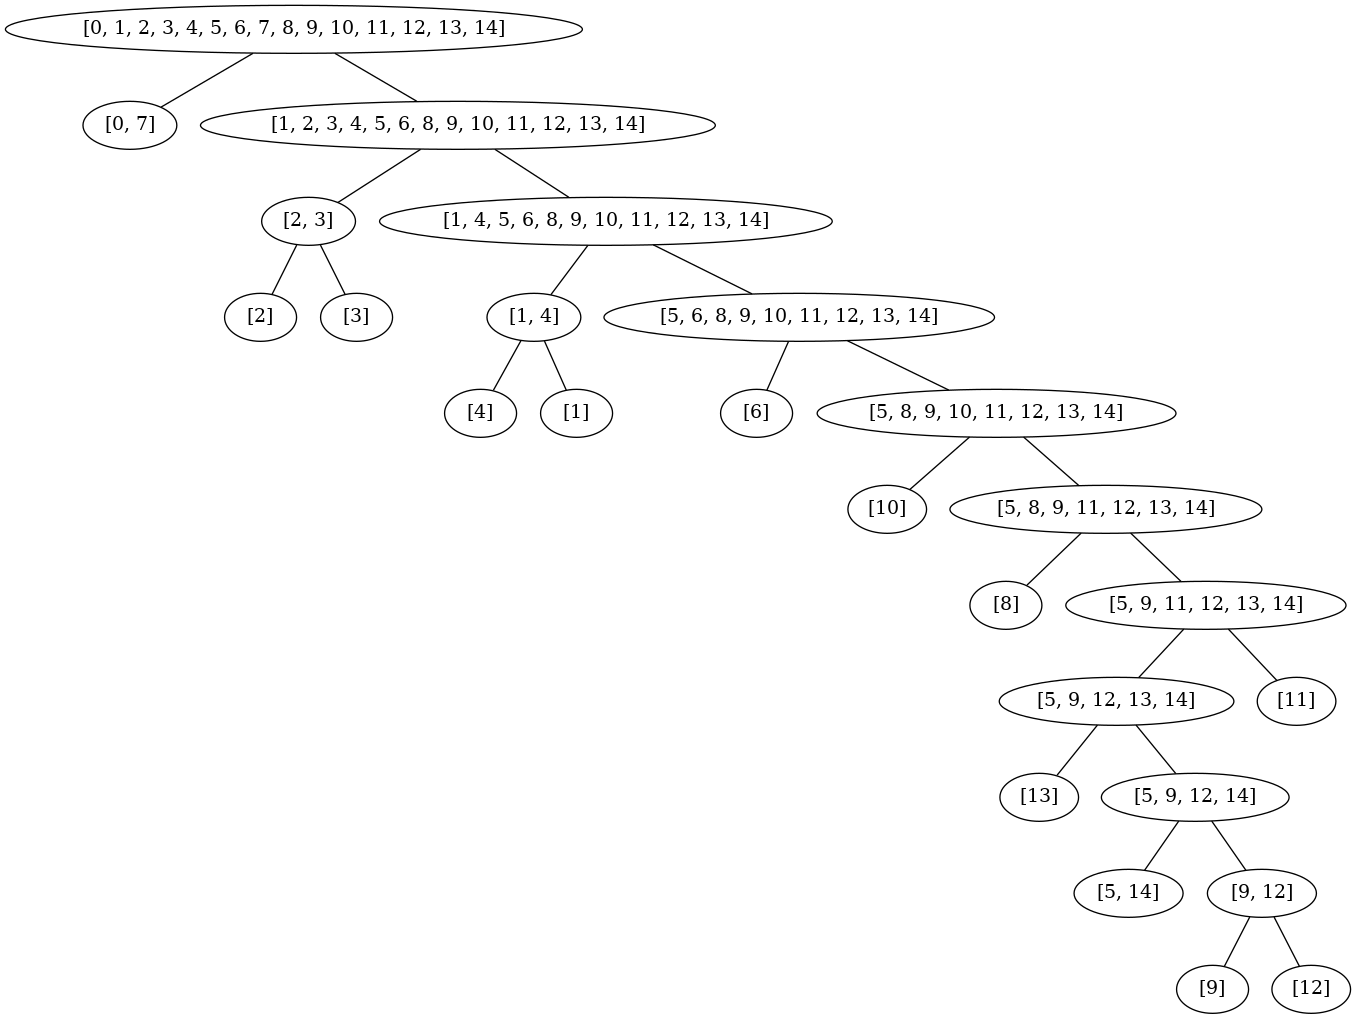

In [18]:
from IPython.display import Image
Image(filename='oc1_tree.png') 